# IMPORT LIBRARIES

In [1]:
import numpy as np
import pandas as pd
import re
import string
from collections import Counter, defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
collection = pd.read_csv('/content/drive/MyDrive/TEXT MINING/Data/processed_dataset.csv')
collection.head()

,text,label,mapped_emotion,mapped_sentiment,processed_text
0,Man I love reddit.,love,joy,positive,man love reddit
1,Right? Considering it’s such an important docu...,gratitude,joy,positive,right considering is important document should...
2,that's adorable asf,amusement,joy,positive,is adorable asf
3,"""Seeeee! We have one of them coloureds too!""",excitement,joy,positive,see have one coloureds too
4,"Lots, play store or apple store vpn. Nord is good",admiration,joy,positive,lot play store apple store vpn nord is good


In [ ]:
processed_texts = collection.processed_text.to_list()

# EMOTION LEXICON

In [ ]:
# Load NRC emotion lexicon
emolex = pd.read_csv("/content/drive/MyDrive/TEXT MINING/Lexicon/NRC-emotion-lexicon-wordlevel-alphabetized-v0.92.txt", sep="\t", header=None, names=["word", "emotion", "association"])
emolex = emolex[emolex["association"] == 1].drop("association", axis=1)

emolex.head(10)

,word,emotion
40,abacus,trust
44,abandon,fear
46,abandon,negative
48,abandon,sadness
51,abandoned,anger
54,abandoned,fear
56,abandoned,negative
58,abandoned,sadness
61,abandonment,anger
64,abandonment,fear


In [ ]:
# Load NRC VAD lexicon (Valence - Arousal _ Dominance)
nrc_vad = pd.read_csv("/content/drive/MyDrive/TEXT MINING/Lexicon/NRC-VAD-Lexicon.txt", sep="\t", header=None, names=["Word", "Valence", "Arousal", "Dominance"])

nrc_vad.head(10)

,Word,Valence,Arousal,Dominance
0,aaaaaaah,0.479,0.606,0.291
1,aaaah,0.520,0.636,0.282
2,aardvark,0.427,0.490,0.437
3,aback,0.385,0.407,0.288
4,abacus,0.510,0.276,0.485
5,abalone,0.500,0.480,0.412
6,abandon,0.052,0.519,0.245
7,abandoned,0.046,0.481,0.130
8,abandonment,0.128,0.430,0.202
9,abashed,0.177,0.644,0.307


In [ ]:
# Load NRC emotion intensity lexicon
nrc_eil = pd.read_csv("/content/drive/MyDrive/TEXT MINING/Lexicon/NRC-Emotion-Intensity-Lexicon-v1.txt", sep="\t", names=["Word", "Emotion", "Intensity"])

nrc_eil.head(10)

,Word,Emotion,Intensity
0,outraged,anger,0.964
1,brutality,anger,0.959
2,hatred,anger,0.953
3,hateful,anger,0.940
4,terrorize,anger,0.939
5,violently,anger,0.938
6,infuriated,anger,0.938
7,furious,anger,0.929
8,furiously,anger,0.927
9,enraged,anger,0.927


In [ ]:
# Load senticnet lexicon
senticnet = pd.read_excel('/content/drive/MyDrive/TEXT MINING/Lexicon/senticnet.xlsx')
senticnet

,CONCEPT,INTROSPECTION,TEMPER,ATTITUDE,SENSITIVITY,PRIMARY EMOTION,SECONDAY EMOTION,POLARITY VALUE,POLARITY INTENSITY,SEMANTICS,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13
0,aah,-0.611,0.0,0.000,0.000,#sadness,NaN,negative,-0.611,weep,cry_eye_out,cry_river,gah,cry
1,abacinate,-0.925,0.0,-0.750,0.000,#grief,#loathing,negative,-0.838,blind,blindspot,disgust,sad,dislike
2,abacterial,0.000,0.0,0.149,0.183,#responsiveness,#acceptance,positive,0.166,abacterial,abacterial,abacterial,abacterial,abacterial
3,abaction,0.000,0.0,0.000,-0.329,#anxiety,NaN,negative,-0.329,abactor,actionless,actless,deactivate,deactivated
4,abactor,0.000,0.0,0.000,-0.329,#anxiety,NaN,negative,-0.329,abaction,actionless,actless,deactivate,deactivated
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295392,🫧,0.660,0.0,0.000,0.000,#joy,NaN,positive,0.660,🆓,<:,[ x,xp,💱
295393,🫨,0.000,0.0,0.000,-0.660,#fear,NaN,negative,-0.660,🫃,📉,☄️,♿,🧬
295394,🫱,0.000,0.0,0.000,0.660,#eagerness,NaN,positive,0.660,🧶,🤹,🎳,👆,⛹️
295395,🫲,0.000,0.0,0.000,0.660,#eagerness,NaN,positive,0.660,🏎️,🔈,📕,💭,👈


In [ ]:
# Some basic df preprocessing
senticnet.columns = [c.lower() for c in senticnet.columns]
senticnet.drop(columns = ['seconday emotion'], inplace = True)
senticnet

,concept,introspection,temper,attitude,sensitivity,primary emotion,polarity value,polarity intensity,semantics,unnamed: 10,unnamed: 11,unnamed: 12,unnamed: 13
0,aah,-0.611,0.0,0.000,0.000,#sadness,negative,-0.611,weep,cry_eye_out,cry_river,gah,cry
1,abacinate,-0.925,0.0,-0.750,0.000,#grief,negative,-0.838,blind,blindspot,disgust,sad,dislike
2,abacterial,0.000,0.0,0.149,0.183,#responsiveness,positive,0.166,abacterial,abacterial,abacterial,abacterial,abacterial
3,abaction,0.000,0.0,0.000,-0.329,#anxiety,negative,-0.329,abactor,actionless,actless,deactivate,deactivated
4,abactor,0.000,0.0,0.000,-0.329,#anxiety,negative,-0.329,abaction,actionless,actless,deactivate,deactivated
...,...,...,...,...,...,...,...,...,...,...,...,...,...
295392,🫧,0.660,0.0,0.000,0.000,#joy,positive,0.660,🆓,<:,[ x,xp,💱
295393,🫨,0.000,0.0,0.000,-0.660,#fear,negative,-0.660,🫃,📉,☄️,♿,🧬
295394,🫱,0.000,0.0,0.000,0.660,#eagerness,positive,0.660,🧶,🤹,🎳,👆,⛹️
295395,🫲,0.000,0.0,0.000,0.660,#eagerness,positive,0.660,🏎️,🔈,📕,💭,👈


In [ ]:
# Rename synonyms columns (previuosly in the same variable, mapped to multiple unnamed columns)
sem = {
    'semantics': 'semantics0',
    'unnamed: 10': 'semantics1',
    'unnamed: 11': 'semantics2',
    'unnamed: 12': 'semantics3',
    'unnamed: 13': 'semantics4'
}

senticnet.rename(columns = sem, inplace = True)
senticnet

,concept,introspection,temper,attitude,sensitivity,primary emotion,polarity value,polarity intensity,semantics0,semantics1,semantics2,semantics3,semantics4
0,aah,-0.611,0.0,0.000,0.000,#sadness,negative,-0.611,weep,cry_eye_out,cry_river,gah,cry
1,abacinate,-0.925,0.0,-0.750,0.000,#grief,negative,-0.838,blind,blindspot,disgust,sad,dislike
2,abacterial,0.000,0.0,0.149,0.183,#responsiveness,positive,0.166,abacterial,abacterial,abacterial,abacterial,abacterial
3,abaction,0.000,0.0,0.000,-0.329,#anxiety,negative,-0.329,abactor,actionless,actless,deactivate,deactivated
4,abactor,0.000,0.0,0.000,-0.329,#anxiety,negative,-0.329,abaction,actionless,actless,deactivate,deactivated
...,...,...,...,...,...,...,...,...,...,...,...,...,...
295392,🫧,0.660,0.0,0.000,0.000,#joy,positive,0.660,🆓,<:,[ x,xp,💱
295393,🫨,0.000,0.0,0.000,-0.660,#fear,negative,-0.660,🫃,📉,☄️,♿,🧬
295394,🫱,0.000,0.0,0.000,0.660,#eagerness,positive,0.660,🧶,🤹,🎳,👆,⛹️
295395,🫲,0.000,0.0,0.000,0.660,#eagerness,positive,0.660,🏎️,🔈,📕,💭,👈


# FEATURE ENGINEERING PREPARATION

In [ ]:
# One Hot Encode categorical variable 'emotion'
emolex_OHE = pd.get_dummies(emolex['emotion']).astype(int)
emolex_features = pd.concat([emolex, emolex_OHE], axis=1)

emolex_features.drop(columns = ['emotion'], inplace = True)
emolex_features = emolex_features.groupby('word').sum()
emolex_features

,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
word,,,,,,,,,,
abacus,0,0,0,0,0,0,0,0,0,1
abandon,0,0,0,1,0,1,0,1,0,0
abandoned,1,0,0,1,0,1,0,1,0,0
abandonment,1,0,0,1,0,1,0,1,1,0
abba,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
zany,0,0,0,0,0,0,0,0,1,0
zeal,0,1,0,0,1,0,1,0,1,1
zealous,0,0,0,0,1,0,1,0,0,1


In [ ]:
# OHE encode emotion intensity values
nrc_features = nrc_eil.pivot_table(index='Word', columns='Emotion', values='Intensity', fill_value=0)
# Add a prefix to distinguish with previous df
nrc_features = nrc_features.rename(columns=lambda x: f"val_{x}" if x != 'Word' else x)

nrc_features

Emotion,val_anger,val_anticipation,val_disgust,val_fear,val_joy,val_sadness,val_surprise,val_trust
Word,,,,,,,,
aaaaaaah,0.000,0.00,0.0,0.344,0.000,0.000,0.000,0.000
aaaah,0.000,0.00,0.0,0.234,0.000,0.000,0.000,0.000
abacus,0.000,0.00,0.0,0.000,0.000,0.000,0.000,0.406
abandon,0.000,0.00,0.0,0.531,0.000,0.703,0.000,0.000
abandoned,0.222,0.00,0.0,0.534,0.000,0.828,0.000,0.000
...,...,...,...,...,...,...,...,...
zany,0.000,0.00,0.0,0.000,0.000,0.000,0.555,0.000
zeal,0.000,0.50,0.0,0.000,0.547,0.000,0.484,0.328
zealous,0.000,0.00,0.0,0.000,0.393,0.000,0.000,0.258


In [ ]:
senticnet

,concept,introspection,temper,attitude,sensitivity,primary emotion,polarity value,polarity intensity,semantics0,semantics1,semantics2,semantics3,semantics4
0,aah,-0.611,0.0,0.000,0.000,#sadness,negative,-0.611,weep,cry_eye_out,cry_river,gah,cry
1,abacinate,-0.925,0.0,-0.750,0.000,#grief,negative,-0.838,blind,blindspot,disgust,sad,dislike
2,abacterial,0.000,0.0,0.149,0.183,#responsiveness,positive,0.166,abacterial,abacterial,abacterial,abacterial,abacterial
3,abaction,0.000,0.0,0.000,-0.329,#anxiety,negative,-0.329,abactor,actionless,actless,deactivate,deactivated
4,abactor,0.000,0.0,0.000,-0.329,#anxiety,negative,-0.329,abaction,actionless,actless,deactivate,deactivated
...,...,...,...,...,...,...,...,...,...,...,...,...,...
295392,🫧,0.660,0.0,0.000,0.000,#joy,positive,0.660,🆓,<:,[ x,xp,💱
295393,🫨,0.000,0.0,0.000,-0.660,#fear,negative,-0.660,🫃,📉,☄️,♿,🧬
295394,🫱,0.000,0.0,0.000,0.660,#eagerness,positive,0.660,🧶,🤹,🎳,👆,⛹️
295395,🫲,0.000,0.0,0.000,0.660,#eagerness,positive,0.660,🏎️,🔈,📕,💭,👈


In [ ]:
# Define numerical mapping for categorical variable 'polarity value'
map = {
    'positive': 1,
    'negative': -1
}

# Apply mapping
senticnet.loc[:, 'polarity value'] = senticnet['polarity value'].map(map)
senticnet

,concept,introspection,temper,attitude,sensitivity,primary emotion,polarity value,polarity intensity,semantics0,semantics1,semantics2,semantics3,semantics4
0,aah,-0.611,0.0,0.000,0.000,#sadness,-1,-0.611,weep,cry_eye_out,cry_river,gah,cry
1,abacinate,-0.925,0.0,-0.750,0.000,#grief,-1,-0.838,blind,blindspot,disgust,sad,dislike
2,abacterial,0.000,0.0,0.149,0.183,#responsiveness,1,0.166,abacterial,abacterial,abacterial,abacterial,abacterial
3,abaction,0.000,0.0,0.000,-0.329,#anxiety,-1,-0.329,abactor,actionless,actless,deactivate,deactivated
4,abactor,0.000,0.0,0.000,-0.329,#anxiety,-1,-0.329,abaction,actionless,actless,deactivate,deactivated
...,...,...,...,...,...,...,...,...,...,...,...,...,...
295392,🫧,0.660,0.0,0.000,0.000,#joy,1,0.660,🆓,<:,[ x,xp,💱
295393,🫨,0.000,0.0,0.000,-0.660,#fear,-1,-0.660,🫃,📉,☄️,♿,🧬
295394,🫱,0.000,0.0,0.000,0.660,#eagerness,1,0.660,🧶,🤹,🎳,👆,⛹️
295395,🫲,0.000,0.0,0.000,0.660,#eagerness,1,0.660,🏎️,🔈,📕,💭,👈


In [ ]:
# OHE emotion column
senticnet_OHE = pd.get_dummies(senticnet['primary emotion']).astype(int)
senticnet_OHE
senticnet_features = pd.concat([senticnet, senticnet_OHE], axis=1)
senticnet_features.drop(columns = ['primary emotion'], inplace = True)
senticnet_features

,concept,introspection,temper,attitude,sensitivity,polarity value,polarity intensity,semantics0,semantics1,semantics2,...,#grief,#joy,#loathing,#melancholy,#pleasantness,#rage,#responsiveness,#sadness,#serenity,#terror
0,aah,-0.611,0.0,0.000,0.000,-1,-0.611,weep,cry_eye_out,cry_river,...,0,0,0,0,0,0,0,1,0,0
1,abacinate,-0.925,0.0,-0.750,0.000,-1,-0.838,blind,blindspot,disgust,...,1,0,0,0,0,0,0,0,0,0
2,abacterial,0.000,0.0,0.149,0.183,1,0.166,abacterial,abacterial,abacterial,...,0,0,0,0,0,0,1,0,0,0
3,abaction,0.000,0.0,0.000,-0.329,-1,-0.329,abactor,actionless,actless,...,0,0,0,0,0,0,0,0,0,0
4,abactor,0.000,0.0,0.000,-0.329,-1,-0.329,abaction,actionless,actless,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295392,🫧,0.660,0.0,0.000,0.000,1,0.660,🆓,<:,[ x,...,0,1,0,0,0,0,0,0,0,0
295393,🫨,0.000,0.0,0.000,-0.660,-1,-0.660,🫃,📉,☄️,...,0,0,0,0,0,0,0,0,0,0
295394,🫱,0.000,0.0,0.000,0.660,1,0.660,🧶,🤹,🎳,...,0,0,0,0,0,0,0,0,0,0
295395,🫲,0.000,0.0,0.000,0.660,1,0.660,🏎️,🔈,📕,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Drop synonyms columns
semantics_columns = [f"semantics{i}" for i in range(5)]
senticnet_features = senticnet_features.drop(columns = semantics_columns, axis = 1)

In [ ]:
# Define set of unique tokens of the collection, it wull be used later to filter lexicons
set_token = set()

for text in processed_texts:

    tokens = text.split()
    for word in tokens:
        set_token.add(word)

len(set_token)

13161

In [ ]:
# Compute descriptive stats excluding zeros, they will be take in consideration later for missing values replacement
nrc_features_no_zeros = nrc_features[nrc_features != 0]
stats_no_zeros = nrc_features_no_zeros.describe()
stats_no_zeros

Emotion,val_anger,val_anticipation,val_disgust,val_fear,val_joy,val_sadness,val_surprise,val_trust
count,1480.000000,862.000000,1092.000000,1763.000000,1264.000000,1290.000000,583.000000,1490.000000
mean,0.499961,0.500283,0.500697,0.499044,0.501782,0.503548,0.500422,0.510451
std,0.206924,0.122763,0.183824,0.208910,0.216414,0.204819,0.197647,0.137962
min,0.011000,0.148000,0.039000,0.016000,0.016000,0.009000,0.055000,0.117000
25%,0.350750,0.414000,0.375000,0.344000,0.328000,0.359000,0.352000,0.422000
50%,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.508000,0.516000
75%,0.641000,0.586000,0.633000,0.656000,0.672000,0.656000,0.648000,0.609000
max,0.964000,0.859000,0.953000,0.984000,0.986000,0.969000,0.930000,0.906000


In [ ]:
# Merge emolex lexicon binary and intensity
## Full outer join to preserve all words
emo_features = pd.merge(emolex_features, nrc_features, how='outer', left_index=True, right_index=True)
emo_features.head(10)

,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,val_anger,val_anticipation,val_disgust,val_fear,val_joy,val_sadness,val_surprise,val_trust
aaaaaaah,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,0.0,0.0,0.344,0.0,0.000,0.000,0.000
aaaah,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,0.0,0.0,0.234,0.0,0.000,0.000,0.000
abacus,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000,0.0,0.0,0.000,0.0,0.000,0.000,0.406
abandon,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.000,0.0,0.0,0.531,0.0,0.703,0.000,0.000
abandoned,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.222,0.0,0.0,0.534,0.0,0.828,0.000,0.000
abandonment,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.438,0.0,0.0,0.609,0.0,0.859,0.523,0.000
abba,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
abbot,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000,0.0,0.0,0.000,0.0,0.000,0.000,0.438
abduction,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.000,0.0,0.0,0.700,0.0,0.750,0.773,0.000
aberrant,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Handle missing values
emotions = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']

for emotion in emotions:
    binary_col = emotion          # binary column
    val_col = f"val_{emotion}"    # corrispondent intensity value

    # handle NaN in binary cases
    emo_features[binary_col] = emo_features[binary_col].fillna(
        (emo_features[val_col] > 0).astype(int)  # insert 1 if correspondant intensity > 0, otherwise 0
    )

    # Gestione dei nulli nelle colonne dei valori
    emo_features[val_col] = emo_features[val_col].fillna(
        emo_features[binary_col].apply(lambda x: 0.5 if x == 1 else 0)  # insert 0.5 (median/mean for all variables) if binary =  1, otherwise 0
    )

emo_features.head(10)

,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,val_anger,val_anticipation,val_disgust,val_fear,val_joy,val_sadness,val_surprise,val_trust
aaaaaaah,0.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,0.0,0.000,0.0,0.0,0.344,0.0,0.000,0.000,0.000
aaaah,0.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,0.0,0.000,0.0,0.0,0.234,0.0,0.000,0.000,0.000
abacus,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000,0.0,0.0,0.000,0.0,0.000,0.000,0.406
abandon,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.000,0.0,0.0,0.531,0.0,0.703,0.000,0.000
abandoned,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.222,0.0,0.0,0.534,0.0,0.828,0.000,0.000
abandonment,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.438,0.0,0.0,0.609,0.0,0.859,0.523,0.000
abba,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.000,0.000,0.000
abbot,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000,0.0,0.0,0.000,0.0,0.000,0.000,0.438
abduction,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.000,0.0,0.0,0.700,0.0,0.750,0.773,0.000
aberrant,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.000,0.000,0.000


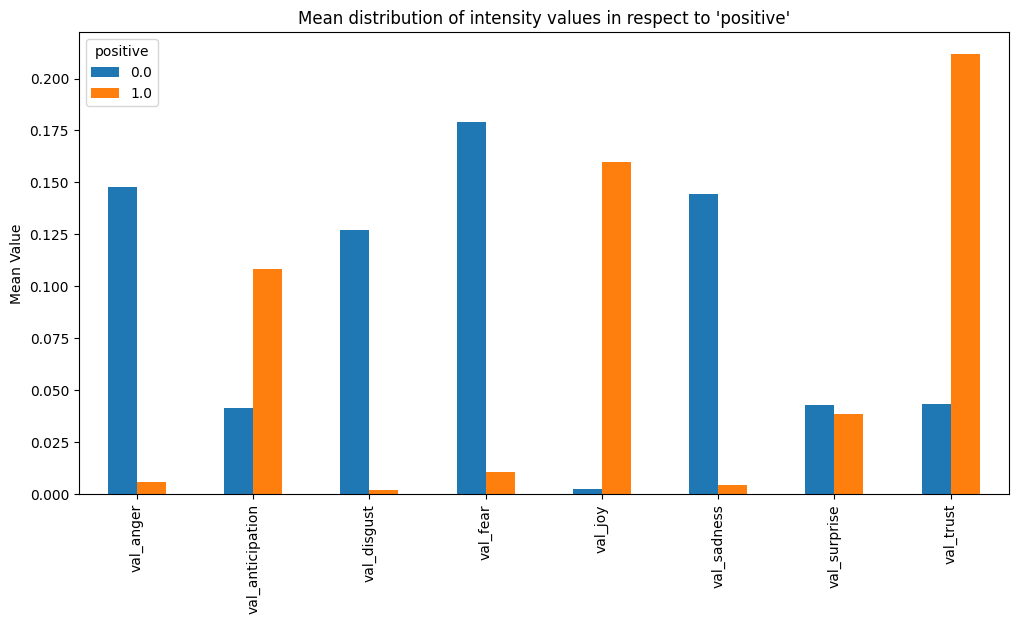

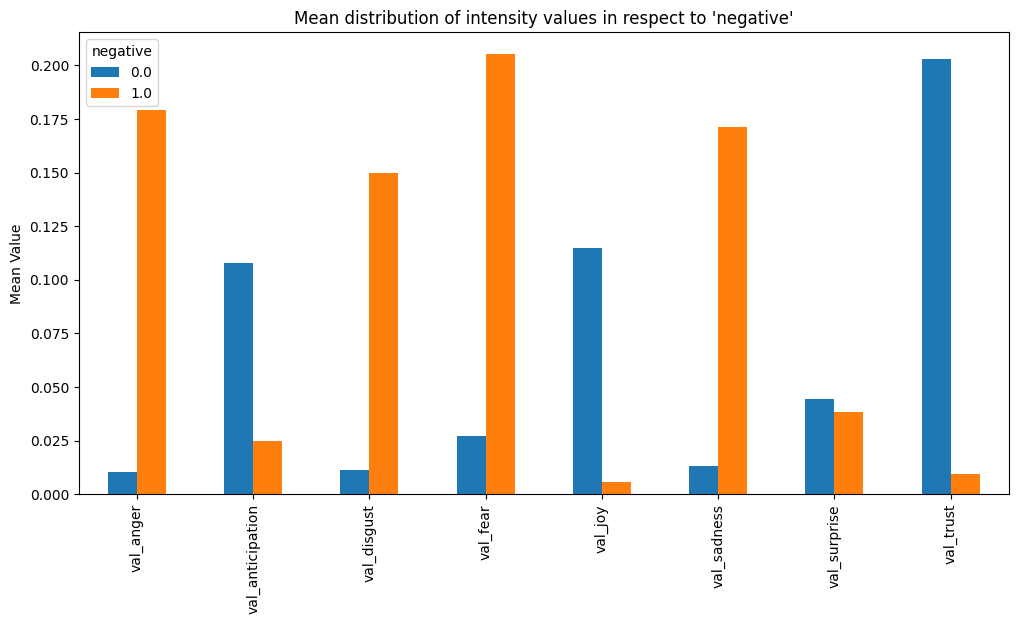

In [ ]:
# Consider row with positive/negative columns not NaN
non_null_df = emo_features.dropna()

# Compute mean of intensity values for grouping of positive/negative values
positive_analysis = non_null_df.groupby('positive')[[
    'val_anger', 'val_anticipation', 'val_disgust', 'val_fear',
    'val_joy', 'val_sadness', 'val_surprise', 'val_trust'
]].mean()

negative_analysis = non_null_df.groupby('negative')[[
    'val_anger', 'val_anticipation', 'val_disgust', 'val_fear',
    'val_joy', 'val_sadness', 'val_surprise', 'val_trust'
]].mean()


# Visualize graphically to look at the variables that are mostly associated with positive/negative
positive_analysis.T.plot(kind='bar', figsize=(12, 6), title="Mean distribution of intensity values in respect to 'positive'")
plt.ylabel('Mean Value')
plt.show()

negative_analysis.T.plot(kind='bar', figsize=(12, 6), title="Mean distribution of intensity values in respect to 'negative'")
plt.ylabel('Mean Value')
plt.show()

In [ ]:
# Handle NaN imputing a values around 1st quartile
## Negative
emo_features['negative'] = emo_features['negative'].fillna(
    ((emo_features['anger'] > 0.325) |
     (emo_features['sadness'] > 0.325) |
     (emo_features['disgust'] > 0.325) |
     (emo_features['fear'] > 0.325)).astype(int)
)

## Positive
emo_features['positive'] = emo_features['positive'].fillna(
    ((emo_features['joy'] > 0.325) |
     (emo_features['trust'] > 0.325)).astype(int)
)

emo_features

,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,val_anger,val_anticipation,val_disgust,val_fear,val_joy,val_sadness,val_surprise,val_trust
aaaaaaah,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000,0.00,0.0,0.344,0.000,0.000,0.000,0.000
aaaah,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000,0.00,0.0,0.234,0.000,0.000,0.000,0.000
abacus,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000,0.00,0.0,0.000,0.000,0.000,0.000,0.406
abandon,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.000,0.00,0.0,0.531,0.000,0.703,0.000,0.000
abandoned,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.222,0.00,0.0,0.534,0.000,0.828,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zeal,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.000,0.50,0.0,0.000,0.547,0.000,0.484,0.328
zealous,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.000,0.00,0.0,0.000,0.393,0.000,0.000,0.258
zen,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.000,0.00,0.0,0.000,0.515,0.000,0.000,0.000
zest,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.000,0.57,0.0,0.000,0.516,0.000,0.000,0.289


# FEATURE ENGINEERING

In [ ]:
# Use the synonims provided by SenticNet lexicon to enlarge the emolex features

# List of ‘semantics’ columns in SenticNet
semantics_columns = [f"semantics{i}" for i in range(5)]
# Create a copy of emo_features
emo_features_expanded = emo_features.copy()

# Iterate on emo_features
for word in emo_features.index:
    # Check if the word is present in SenticNet
    if word in senticnet['concept'].values:
        # If present retrieving associated synonyms
        synonyms = senticnet.loc[senticnet['concept'] == word, semantics_columns].values.flatten()
        # Remove possible NaN or duplicated
        synonyms = set(synonyms[~pd.isnull(synonyms)])

        # Add a new line for each synonym
        for synonym in synonyms:
            # Check wether is not already present in emo_features
            if synonym not in emo_features_expanded.index:
                # Duplicate original row
                new_row = emo_features.loc[word].copy()
                # Add as a new row
                emo_features_expanded.loc[synonym] = new_row

emo_features_expanded

,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,val_anger,val_anticipation,val_disgust,val_fear,val_joy,val_sadness,val_surprise,val_trust
aaaaaaah,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.344,0.000,0.000,0.0,0.000
aaaah,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.234,0.000,0.000,0.0,0.000
abacus,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000,0.0,0.0,0.000,0.000,0.000,0.0,0.406
abandon,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.000,0.0,0.0,0.531,0.000,0.703,0.0,0.000
abandoned,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.222,0.0,0.0,0.534,0.000,0.828,0.0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
vipassana,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.266,0.000,0.0,0.000
fresh_blood,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.000,0.5,0.0,0.000,0.500,0.000,0.5,0.000
new_blood,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.000,0.5,0.0,0.000,0.500,0.000,0.5,0.000
youngblood,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.000,0.5,0.0,0.000,0.500,0.000,0.5,0.000


In [ ]:
# Reset emo_features_expanded's index to trasform in a column for uniformity
emo_features_expanded = emo_features_expanded.reset_index()
emo_features_expanded.rename(columns={'index': 'word'}, inplace=True)

In [ ]:
print(len(emo_features_expanded), emo_features_expanded.word.nunique())
print(len(senticnet_features), senticnet_features.concept.nunique())
print(len(nrc_vad), nrc_vad.Word.nunique())

13500 13500
295397 295396
19971 19970


In [ ]:
senticnet_features.dropna(subset=['concept'], inplace=True)
nrc_vad.dropna(subset=['Word'], inplace=True)

print(len(senticnet_features), senticnet_features.concept.nunique())
print(len(nrc_vad), nrc_vad.Word.nunique())

295396 295396
19970 19970


In [ ]:
senticnet_features.rename(columns={'concept': 'word'}, inplace=True)
nrc_vad.rename(columns={'Word': 'word'}, inplace=True)

In [ ]:
# 1st join
merged_1 = pd.merge(
    emo_features_expanded,
    senticnet_features,
    how='outer',
    on='word'
)

#  2nd join
final_merged = pd.merge(
    merged_1,
    nrc_vad,
    how='outer',
    on='word'
)

final_merged

,word,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,...,#melancholy,#pleasantness,#rage,#responsiveness,#sadness,#serenity,#terror,Valence,Arousal,Dominance
0,= 3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
1,= \,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
2,= ],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
3,= p,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
4,=.=,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300788,🫧,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
300789,🫨,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
300790,🫱,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
300791,🫲,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN


In [ ]:
# Define a df with words that appears in all lexicons to be used for NaN imputation
non_null_data = final_merged.dropna()
# Keep only the words that appears in our corpus
final_merged = final_merged[final_merged['word'].isin(set_token)]

emolex_columns = ['anger', 'anticipation', 'disgust', 'fear', 'joy',
                  'negative', 'positive', 'sadness', 'surprise', 'trust']
sentic_columns = ['#acceptance', '#anger', '#annoyance', '#anxiety', '#bliss', '#calmness',
                  '#contentment', '#delight', '#disgust', '#dislike', '#eagerness',
                  '#ecstasy', '#enthusiasm', '#fear', '#grief', '#joy', '#loathing',
                  '#melancholy', '#pleasantness', '#rage', '#responsiveness', '#sadness',
                  '#serenity', '#terror']

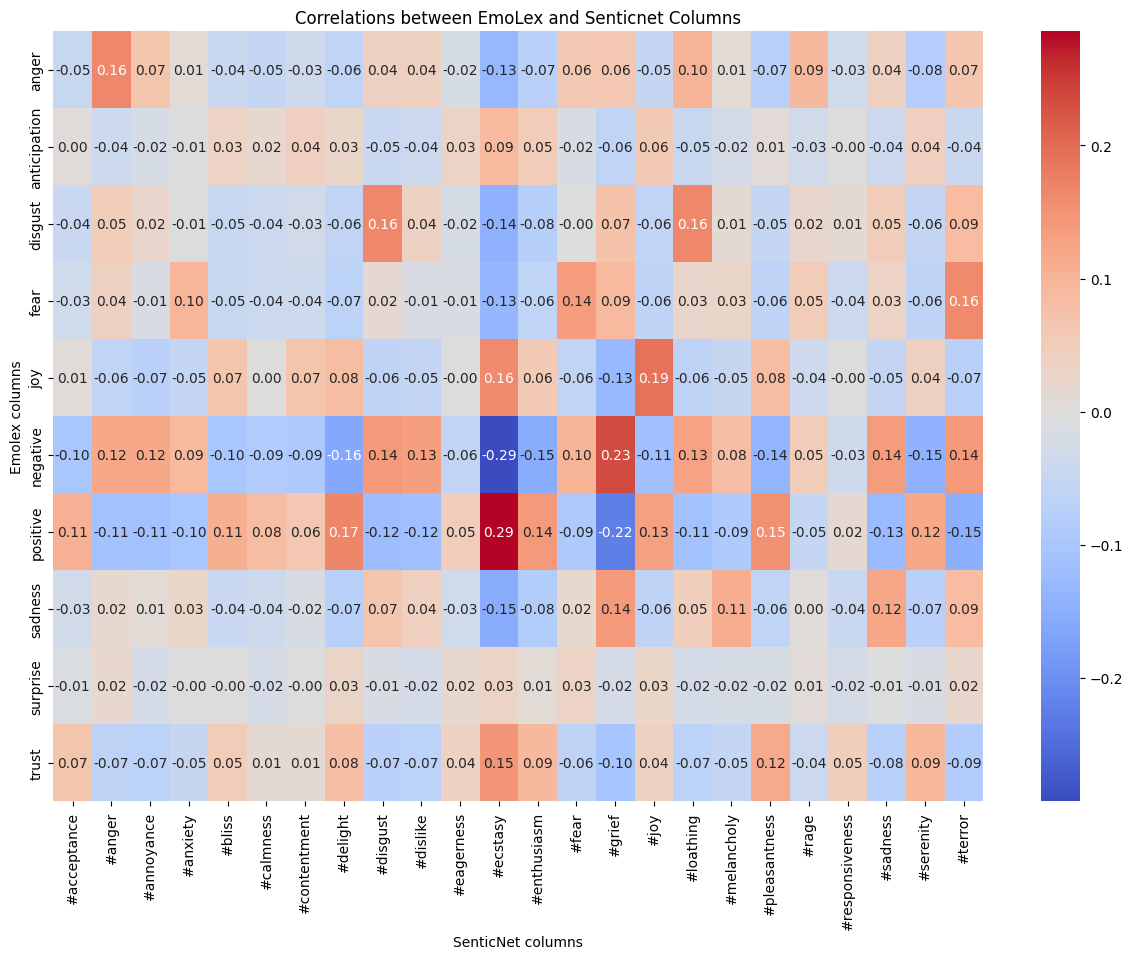

In [ ]:
# Compute correlations
correlation_matrix = non_null_data[emolex_columns + sentic_columns].corr()

# Extract only correlations between emolex and sentic
emolex_to_sentic_corr = correlation_matrix.loc[emolex_columns, sentic_columns]

# View correlation heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(emolex_to_sentic_corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlations between EmoLex and Senticnet Columns')
plt.xlabel('SenticNet columns')
plt.ylabel('Emolex columns')
plt.show()

In [ ]:
# we define a mapping using logical sense and correlations to handle
# NaN emolexes at SenticNet not NaN
map_senticnet_to_nrc = {
    "#acceptance": ["positive"],
    "#anger": ["anger", "negative"],
    "#annoyance": ["negative"],
    "#anxiety": ["anticipation", "fear", "sadness", "negative"],
    "#bliss": ["joy", "positive"],
    "#calmness": ["positive"],
    "#contentment": ["joy", "positive"],
    "#delight": [ "positive"],
    "#disgust": ["disgust", "negative"],
    "#dislike": ["anger", "disgust", "negative"],
    "#eagerness": ['positive'],
    "#ecstasy": ["trust", "joy", "anticipation", "positive"],
    "#enthusiasm": ["joy", "trust", "positive"],
    "#fear": ["fear", "negative"],
    "#grief": ["sadness", "negative"],
    "#joy": ["joy", "positive"],
    "#loathing": ["anger", "disgust", "negative"],
    "#melancholy": ["sadness", "negative"],
    "#pleasantness": ["joy", "trust", "positive"],
    "#rage": ["anger", "negative"],
    "#responsiveness": ["trust"],
    "#sadness": ["sadness", "negative"],
    "#serenity": ["trust", "joy", "positive"],
    "#terror": ["fear", "disgust", "anger", "negative"]
}

In [ ]:
# NaN before mapping
final_merged.isna().sum()

,0
word,0
anger,1273
anticipation,1273
disgust,1273
fear,1273
joy,1273
negative,1273
positive,1273
sadness,1273
surprise,1273


In [ ]:
# Impute missing using defined mapping
for sentic_column, emolex_columns_mapped in map_senticnet_to_nrc.items():
    # Check rows where sentic_column is 1
    rows_with_one = final_merged[sentic_column] == 1

    for emolex_column in emolex_columns:
        # Pick rows with emolex NaN
        rows_with_null = final_merged[emolex_column].isna()

        # Update rows where Sentic == 1 and EmoLex is null
        rows_to_update_one = rows_with_one & rows_with_null
        if emolex_column in emolex_columns_mapped:
            # Set binary EmoLex to 1
            final_merged.loc[rows_to_update_one, emolex_column] = 1

            # Set val_* a 0.5 if existing
            if emolex_column not in ['positive', 'negative']:
                val_column = f"val_{emolex_column}"
                if val_column in final_merged.columns:
                    final_merged.loc[rows_to_update_one, val_column] = 0.5
        else:
            # Set complementary to 0
            final_merged.loc[rows_to_update_one, emolex_column] = 0

            # Set val_* complementary to 0
            if emolex_column not in ['positive', 'negative']:
                val_column = f"val_{emolex_column}"
                if val_column in final_merged.columns:
                    final_merged.loc[rows_to_update_one, val_column] = 0


final_merged

,word,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,...,#melancholy,#pleasantness,#rage,#responsiveness,#sadness,#serenity,#terror,Valence,Arousal,Dominance
102,aah,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN
118,abandon,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.052,0.519,0.245
120,abandoned,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.046,0.481,0.130
218,abbreviated,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
240,abdomen,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.469,0.462,0.471
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299746,zone,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.531,0.349,0.382
299750,zoo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.760,0.520,0.580
299753,zoom,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.490,0.520,0.462
299800,zucchini,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.510,0.321,0.250


In [ ]:
#NaN after mapping
final_merged.isna().sum()

,0
word,0
anger,1273
anticipation,1273
disgust,1273
fear,1273
joy,1273
negative,1273
positive,1273
sadness,1273
surprise,1273


In [ ]:
# Define a mapping for the opposite process
map_emolex_to_senticnet = {
    'anger': '#anger',
    'anticipation': '#ecstasy',
    'disgust': '#disgust',
    'fear': '#fear',
    'joy': '#joy',
    'sadness': '#sadness',
    'surprise': '#delight',
    'trust': '#pleasentness',
    'positive': '#ecstasy',
    'negative':  '#grief'
}

In [ ]:
# Iterate on df's row
for index, row in final_merged.iterrows():
    # Check if SenticNet is NaN
    if row[sentic_columns].isna().all():
        # Get active EmoLex columns
        active_emotions = [col for col in emolex_columns if row[col] == 1]

        # Case 1: Only one active emotion
        if len(active_emotions) == 1:
            # Map directly
            emo = active_emotions[0]
            sentic_col = map_emolex_to_senticnet.get(emo, None)
            if sentic_col:
                final_merged.loc[index, sentic_columns] = 0  # ResetSenticNet
                final_merged.loc[index, sentic_col] = 1  # Assign 1

        # Case 2: Two active emotions, one is positive/negative
        elif len(active_emotions) == 2 and ('positive' in active_emotions or 'negative' in active_emotions):
            # Ignore positive/negative
            non_positive_negative = [e for e in active_emotions if e not in ['positive', 'negative']]

            if non_positive_negative:  # Check if there are any remaining emotions
                emo = non_positive_negative[0]
                sentic_col = map_emolex_to_senticnet.get(emo, None)
                if sentic_col:
                    final_merged.loc[index, sentic_columns] = 0  # Reset SenticNet
                    final_merged.loc[index, sentic_col] = 1  # Assign 1

        # Case 3: More active emotions (excluding positive/negative)
        elif len(active_emotions) > 2:
            non_positive_negative = [e for e in active_emotions if e not in ['positive', 'negative']]

            # Use val_* columns to decide priority
            val_columns = [f'val_{emo}' for emo in non_positive_negative]
            val_values = {emo: row[f'val_{emo}'] for emo in non_positive_negative if f'val_{emo}' in row}

            # Find the emotion with the highest intensity value
            max_val = max(val_values.values(), default=0)
            top_emotions = [emo for emo, val in val_values.items() if val == max_val]

            # If there is only one maximum value, assign the mapping
            if len(top_emotions) == 1:
                sentic_col = map_emolex_to_senticnet.get(top_emotions[0], None)
                if sentic_col:
                    final_merged.loc[index, sentic_columns] = 0  # Reset SenticNet
                    final_merged.loc[index, sentic_col] = 1  # Assign 1

            # If there are several emotions with the same maximum value, assign multiple columns
            else:
                final_merged.loc[index, sentic_columns] = 0  # Reset SenticNet
                for emo in top_emotions:
                    sentic_col = map_emolex_to_senticnet.get(emo, None)
                    if sentic_col:
                        final_merged.loc[index, sentic_col] = 1  # Assign 1 to each

final_merged = final_merged.iloc[:, :-1]
final_merged.isna().sum()

<ipython-input-97-da70a7b8c347>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_merged.loc[index, sentic_col] = 1  # Assign 1


,0
word,0
anger,1273
anticipation,1273
disgust,1273
fear,1273
joy,1273
negative,1273
positive,1273
sadness,1273
surprise,1273


<Axes: >

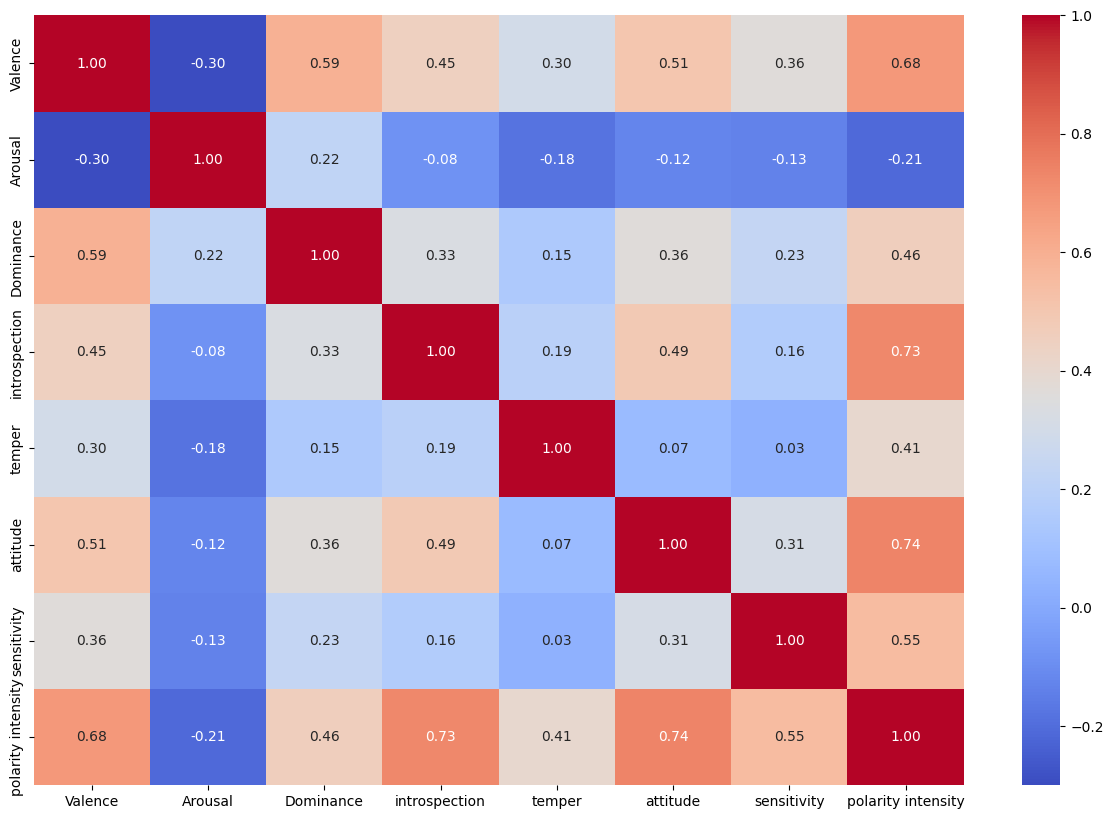

In [ ]:
# Let us now analyse two sets of columns of interest to assess their possible use for NaN imputation
columns_to_analyze = ['Valence', 'Arousal', 'Dominance', 'introspection', 'temper', 'attitude', 'sensitivity', 'polarity intensity']
# Compute correlation matrix - use only word that appears in every lexicon
correlation_matrix = non_null_data[columns_to_analyze].corr()
# Visualize correlation heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')

Given the presence of a fair degree of correlation between the variables we try to define models to be used to impute missing values, although they will certainly be inaccurate it is a better estimate than a simple use of zero or mean/median

In [ ]:
# Define two set of features
vad_features = ['Valence', 'Arousal', 'Dominance']
sentic_features = ['introspection', 'temper', 'sensitivity', 'attitude', 'polarity intensity', 'polarity value']

# Use a copy for analysis
df = non_null_data.copy()

# Dictionaries to save models and performances
models_vad_to_sentic = {}
performances_vad_to_sentic = {}
models_sentic_to_vad = {}
performances_sentic_to_vad = {}

# Function to create a pipeline with polynomial terms
def build_pipeline():
    return Pipeline([
        ('polynomial', PolynomialFeatures(include_bias=False)),
        ('regressor', LinearRegression())
    ])

# Function to optimise the polynomial degree
def optimize_polynomial_degree(X_train, y_train, max_degree):
    pipeline = build_pipeline()
    param_grid = {'polynomial__degree': range(1, max_degree + 1)}  # text from 1 to max degree
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error') # use 5 cv, minimize mse
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_, grid_search.best_params_['polynomial__degree']

# Models to predict the 5 features of SenticNet using VAD
for feature in sentic_features:
    # Define input and target
    X = df[vad_features]
    y = df[feature]

    # Split train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777)

    # Optimize polinomial degree
    best_pipeline, best_degree = optimize_polynomial_degree(X_train, y_train, max_degree=6)

    # Evaluate model
    y_pred = best_pipeline.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Save model and performances
    models_vad_to_sentic[feature] = best_pipeline
    performances_vad_to_sentic[feature] = {'MSE': mse, 'R²': r2, 'Best Degree': best_degree}

# Models for predicting Valence, Arousal, Dominance using the 5 features of SenticNet
for feature in vad_features:
    # Input e target
    X = df[sentic_features]
    y = df[feature]

    # Split train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777)

    # Optimize polinomial degree
    best_pipeline, best_degree = optimize_polynomial_degree(X_train, y_train, max_degree=6)

    # Evaluate model
    y_pred = best_pipeline.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Save model and performances
    models_sentic_to_vad[feature] = best_pipeline
    performances_sentic_to_vad[feature] = {'MSE': mse, 'R²': r2, 'Best Degree': best_degree}

# Show all performances
print("Performance VAD -> SenticNet:")
for feature, performance in performances_vad_to_sentic.items():
    print(f"{feature}: MSE = {performance['MSE']:.4f}, R² = {performance['R²']:.4f}, Best Degree = {performance['Best Degree']}")

print("\nPerformance SenticNet -> VAD:")
for feature, performance in performances_sentic_to_vad.items():
    print(f"{feature}: MSE = {performance['MSE']:.4f}, R² = {performance['R²']:.4f}, Best Degree = {performance['Best Degree']}")


Performance VAD -> SenticNet:
introspection: MSE = 0.2389, R² = 0.2423, Best Degree = 4
temper: MSE = 0.0725, R² = 0.1145, Best Degree = 3
sensitivity: MSE = 0.1351, R² = 0.1533, Best Degree = 3
attitude: MSE = 0.1831, R² = 0.2834, Best Degree = 3
polarity intensity: MSE = 0.2593, R² = 0.4942, Best Degree = 3
polarity value: MSE = 0.4526, R² = 0.5470, Best Degree = 3

Performance SenticNet -> VAD:
Valence: MSE = 0.0314, R² = 0.5436, Best Degree = 3
Arousal: MSE = 0.0295, R² = 0.1239, Best Degree = 3
Dominance: MSE = 0.0258, R² = 0.2693, Best Degree = 3


We now use the estimated models to impute the values if we have the necessary predictors, if this is not possible we proceed to impute with the median

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# CCalculate the median for each variable of VAD
vad_medians = {feature: final_merged[feature].median() for feature in vad_features}

# Iterate on df's row
for idx, row in final_merged.iterrows():
    #  Check if all VAD variables are NaN
    if row[vad_features].isna().all():
        # Check if all SenticNet are NaN
        if row[sentic_features].isna().all():
            # Impute with the median for each VAD variable
            for vad_feature in vad_features:
                final_merged.at[idx, vad_feature] = vad_medians[vad_feature]
        else:
            # Use saved models to predict VAD variables
            for vad_feature in vad_features:
                if vad_feature in models_sentic_to_vad:
                    model = models_sentic_to_vad[vad_feature]

                    # Prepares input for the model (SenticNet non-zero)
                    X_input = pd.DataFrame([row[sentic_features]], columns=sentic_features)

                    # Predict
                    X_input_array = X_input.to_numpy()
                    prediction = model.predict(X_input_array)[0]
                    final_merged.at[idx, vad_feature] = prediction

In [ ]:
final_merged.isna().sum()

,0
word,0
anger,1273
anticipation,1273
disgust,1273
fear,1273
joy,1273
negative,1273
positive,1273
sadness,1273
surprise,1273


In [ ]:
# Now do the opposite
sentic_medians = {feature: final_merged[feature].median() for feature in sentic_features}

for idx, row in final_merged.iterrows():
    if row[sentic_features].isna().all():
        if row[vad_features].isna().all():
            for sentic_feature in sentic_features:
                final_merged.at[idx, sentic_feature] = sentic_medians[sentic_feature]
        else:
            for sentic_feature in sentic_features:
                if sentic_feature in models_vad_to_sentic:

                    model = models_vad_to_sentic[sentic_feature]
                    X_input = pd.DataFrame([row[vad_features]], columns=vad_features)

                    X_input_array = X_input.to_numpy()
                    prediction = model.predict(X_input_array)[0]
                    final_merged.at[idx, sentic_feature] = prediction

In [ ]:
final_merged.isna().sum()

,0
word,0
anger,1273
anticipation,1273
disgust,1273
fear,1273
joy,1273
negative,1273
positive,1273
sadness,1273
surprise,1273


In [ ]:
final_merged

,word,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,...,#melancholy,#pleasantness,#rage,#responsiveness,#sadness,#serenity,#terror,Valence,Arousal,Dominance
102,aah,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.273372,0.506065,0.358236
118,abandon,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.052000,0.519000,0.245000
120,abandoned,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.046000,0.481000,0.130000
218,abbreviated,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.339459,0.515586,0.426515
240,abdomen,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.469000,0.462000,0.471000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299746,zone,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.531000,0.349000,0.382000
299750,zoo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.760000,0.520000,0.580000
299753,zoom,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.490000,0.520000,0.462000
299800,zucchini,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.510000,0.321000,0.250000


In [ ]:
# Fill remaining NaN with 0
final_merged.fillna(0, inplace=True)
final_merged.set_index('word', inplace = True)
final_merged.head()

,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,...,#melancholy,#pleasantness,#rage,#responsiveness,#sadness,#serenity,#terror,Valence,Arousal,Dominance
word,,,,,,,,,,,,,,,,,,,,,
aah,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.273372,0.506065,0.358236
abandon,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.052000,0.519000,0.245000
abandoned,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.046000,0.481000,0.130000
abbreviated,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.339459,0.515586,0.426515
abdomen,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.469000,0.462000,0.471000


In [ ]:
# Save csv
final_merged.to_csv('/content/drive/MyDrive/TEXT MINING/Data/emotional_vectors.csv')

In [ ]:
len(set(final_merged.index))

9446